# Clustering and Predicting Cell Types from Single-Cell RNA Sequencing

In this notebook, we analyze the **PBMC3k dataset**, a single-cell RNA sequencing dataset of ~3,000 peripheral blood mononuclear cells (PBMCs) from 10x Genomics. This dataset includes diverse immune cell populations such as T cells, B cells, NK cells, and monocytes, making it a standard benchmark for computational single-cell analysis.

Our goal is twofold. First, we apply **unsupervised learning** methods (PCA, Leiden clustering, K-means, and hierarchical clustering) to group cells by gene expression and identify marker genes through **differential expression analysis**. Second, we use **supervised learning** to build predictive models that classify cells into known types. We compare **Logistic Regression**, **Random Forests**, and a **Multi-Layer Perceptron (MLP) neural network** trained with early stopping and elastic net regularization.

This combined approach demonstrates how machine learning can be used both to **discover populations** and to **automatically classify cells**, providing a complete workflow for single-cell transcriptomics.

### Package imports
We import Scanpy for single-cell processing, sklearn for traditional ML models, PyTorch for neural networks, and matplotlib for visualization. Set random seed for reproducibility. 


In [254]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim

seed=2
np.random.seed(seed)
torch.manual_seed(seed)

### Load dataset
We load the PBMC3k dataset using Scanpy. This dataset contains ~3,000 immune cells and their gene expression profiles. 
It is commonly used for benchmarking single-cell RNA-seq workflows. Each cell is a row and each gene is a feature.

In [255]:
adata = sc.datasets.pbmc3k()
print(adata)

# Store the original full dataset in adata_full before HVG subsetting
adata_full = adata.raw.to_adata() if adata.raw is not None else adata.copy()

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


### Data preprocessing

We perform standard preprocessing steps:
1. Filter out low-quality cells and genes.
2. Calculate percentage of mitochondrial genes per cell.
3. Normalize counts per cell to account for sequencing depth.
4. Log-transform expression values.
5. Identify highly variable genes (HVGs) for downstream analysis.
6. Scale data and reduce dimensionality using PCA.
7. Compute nearest neighbors and UMAP embedding for visualization.

In [256]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

## Unsupervised learning

The first part of this analysis focuses on **unsupervised learning**, which is the standard approach for exploring single-cell RNA-seq data. Since we do not have ground-truth cell labels, the goal is to identify **natural groupings of cells** based on their gene expression profiles. We apply dimensionality reduction (PCA and UMAP) to capture the global structure of the data, followed by clustering methods such as **Leiden graph-based clustering, K-means, and hierarchical clustering** to partition cells into putative populations. By comparing the clustering results and performing differential expression analysis between groups, we can discover whether clusters correspond to biologically distinct cell types and evaluate the robustness of different clustering strategies.

### Leiden clustering

We apply the Leiden clustering algorithm to discover groups of cells based solely on gene expression. 
This step is unsupervised and helps us understand the underlying structure of the dataset.

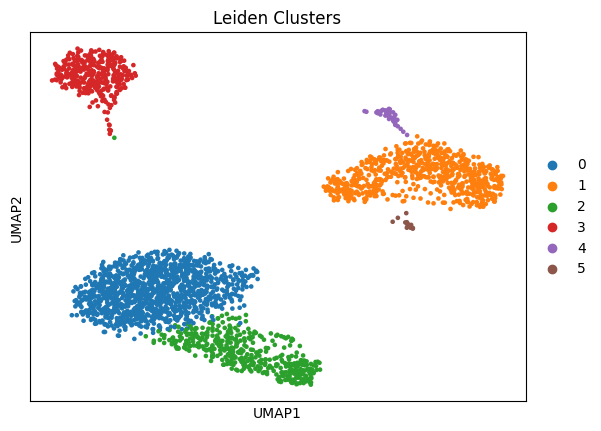

In [257]:
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'], title='Leiden Clusters')

*Fig. 1* | *UMAP visualization of cells with annotation of Leiden clusters.*

### Annotate Cell Types
We use known immune cell marker genes to annotate clusters with biologically meaningful labels, such as T cells, B cells, NK cells, monocytes, dendritic cells, and megakaryocytes. This allows us to create labels for supervised learning.

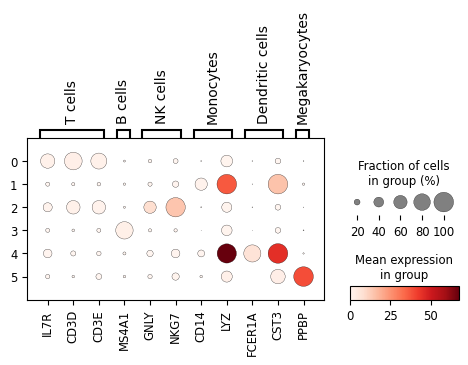

In [258]:
marker_genes = {
    "T cells": ["IL7R", "CD3D", "CD3E"],
    "B cells": ["MS4A1"],
    "NK cells": ["GNLY", "NKG7"],
    "Monocytes": ["CD14", "LYZ"],
    "Dendritic cells": ["FCER1A", "CST3"],
    "Megakaryocytes": ["PPBP"],
}

# Use full data for dotplot
# Ensure adata_full has the same cell indices as adata
adata_full.obs['leiden'] = adata.obs['leiden'].copy()
sc.pl.dotplot(adata_full, marker_genes, groupby='leiden')

*Fig. 2* | *Expression of immune cell gene markers across leiden clusters.*

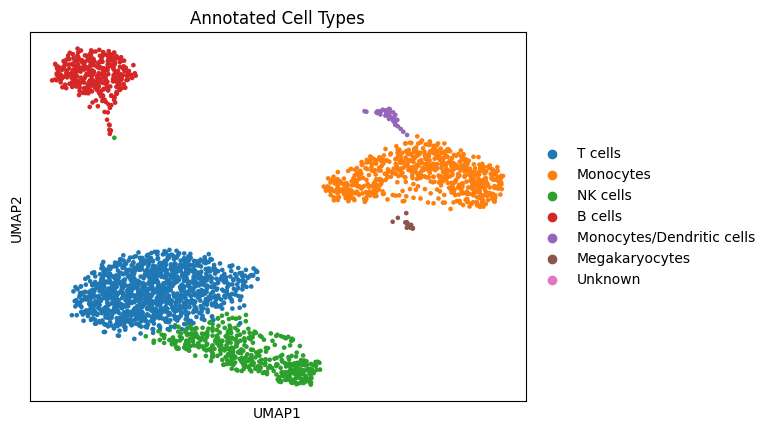

In [259]:
cluster2celltype = {
    '0': 'T cells',
    '1': 'Monocytes',
    '2': 'NK cells',
    '3': 'B cells',
    '4': 'Monocytes/Dendritic cells',
    '5': 'Megakaryocytes'
}
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster2celltype)
adata.obs['cell_type'] = adata.obs['cell_type'].cat.add_categories(["Unknown"]).fillna("Unknown")

sc.pl.umap(adata, color='cell_type', title='Annotated Cell Types')

*Fig. 3* | *UMAP visualization of cells with cell type annotation.*

### K-means clustering on PCA space
Here we apply K-means clustering on the PCA-reduced representation of the data,
and compare the results to the Leiden graph-based clusters.

Unlike Leiden, which is graph-based and can detect irregular cluster shapes,
K-means partitions the data into spherical clusters. We use the same PCA embedding
to ensure a fair comparison.

=== K-means vs. Leiden Comparison ===
Adjusted Rand Index (ARI): 0.895
Normalized Mutual Information (NMI): 0.871
Homogeneity: 0.906


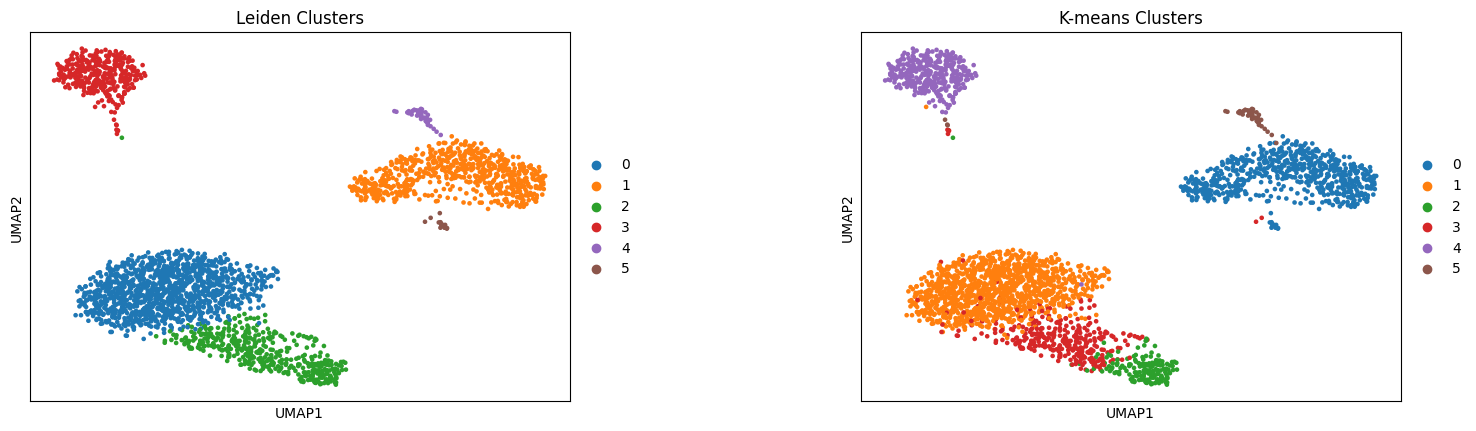

In [260]:
# Run K-means on PCA space
X_pca = adata.obsm['X_pca']
n_clusters = adata.obs['leiden'].nunique()  # match Leiden cluster count for fairness
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
adata.obs['kmeans'] = kmeans.fit_predict(X_pca).astype(str)

# Compare clustering results
ari = adjusted_rand_score(adata.obs['leiden'], adata.obs['kmeans'])
nmi = normalized_mutual_info_score(adata.obs['leiden'], adata.obs['kmeans'])
hom = homogeneity_score(adata.obs['leiden'], adata.obs['kmeans'])

print("=== K-means vs. Leiden Comparison ===")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")
print(f"Homogeneity: {hom:.3f}")

# Visualization
sc.pl.umap(
    adata, 
    color=['leiden', 'kmeans'], 
    wspace=0.4,
    title=['Leiden Clusters', 'K-means Clusters']
)


*Fig. 4* | *UMAP visualization of cells with annotation of Leiden clusters and K-means clusters.*

### Hierarchical clustering on PCA space

We apply agglomerative hierarchical clustering on the PCA-reduced data and compare the results with Leiden clusters. Hierarchical clustering
does not assume spherical clusters and instead builds a tree of nested partitions. Here we cut the tree at the same number of clusters as Leiden for a fair comparison.

=== Hierarchical vs. Leiden Comparison ===
Adjusted Rand Index (ARI): 0.888
Normalized Mutual Information (NMI): 0.858
Homogeneity: 0.878


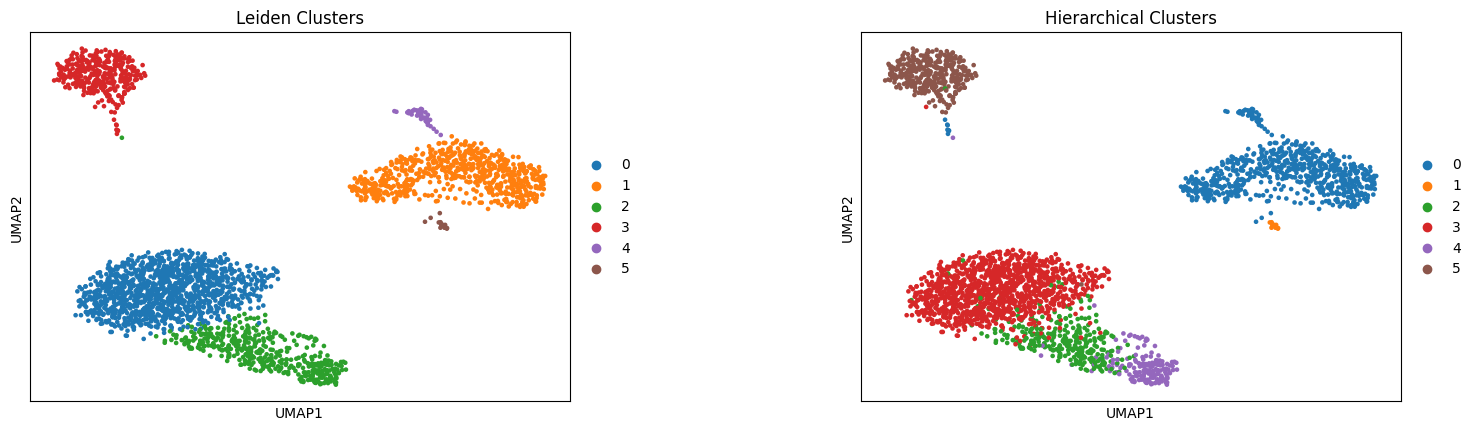

In [261]:
# Run Agglomerative clustering
n_clusters = adata.obs['leiden'].nunique()  # same cluster count as Leiden
agg = AgglomerativeClustering(n_clusters=n_clusters)
adata.obs['hierarchical'] = agg.fit_predict(X_pca).astype(str)

# Compare clustering results
ari_h = adjusted_rand_score(adata.obs['leiden'], adata.obs['hierarchical'])
nmi_h = normalized_mutual_info_score(adata.obs['leiden'], adata.obs['hierarchical'])
hom_h = homogeneity_score(adata.obs['leiden'], adata.obs['hierarchical'])

print("=== Hierarchical vs. Leiden Comparison ===")
print(f"Adjusted Rand Index (ARI): {ari_h:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi_h:.3f}")
print(f"Homogeneity: {hom_h:.3f}")

# Visualization
sc.pl.umap(
    adata, 
    color=['leiden', 'hierarchical'], 
    wspace=0.4,
    title=['Leiden Clusters', 'Hierarchical Clusters']
)

*Fig. 5* | *UMAP visualization of cells with annotation of Leiden clusters and Hierarchical clusters.*

After performing **Leiden, K-means, and hierarchical clustering**, we observed that one of the Leiden clusters (cluster 2) was **split into two subclusters** by both K-means and hierarchical clustering. This suggested that cluster 2 might contain **biologically distinct subpopulations** that are not fully captured by the graph-based Leiden algorithm. To investigate whether these subclusters reflect real differences in gene expression, we performed **differential expression analysis** within cluster 2, comparing the two K-means-defined subclusters (K-mean clusters 2 and 3). This allows us to identify genes that are specifically enriched in one subcluster versus the other and to assess whether the observed split corresponds to meaningful biological distinctions.

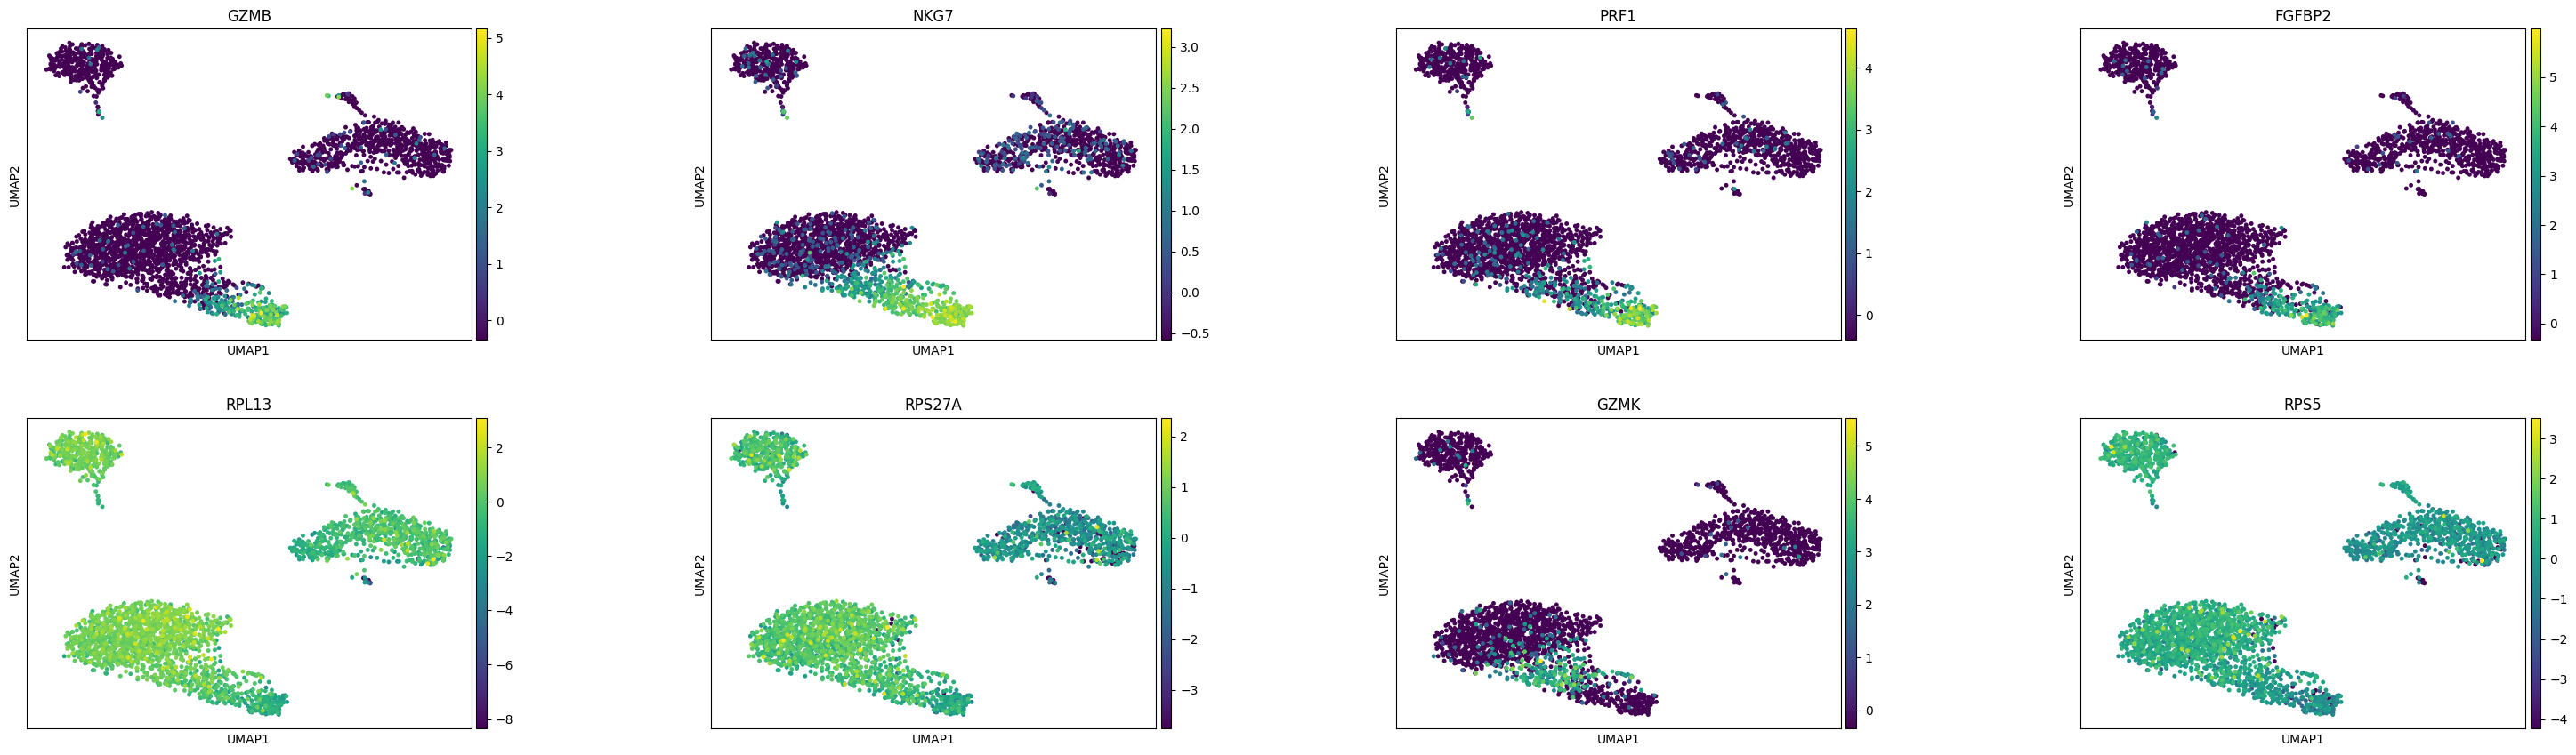

In [262]:
# Subset cluster 2 cells
clusters_of_interest = ['2','3']  # K-means subcluster labels within Leiden 2
adata_sub = adata[adata.obs['kmeans'].isin(clusters_of_interest)].copy()
adata_sub.obs['kmeans'] = adata_sub.obs['kmeans'].cat.remove_unused_categories()

# Differential expression
sc.tl.rank_genes_groups(adata_sub, groupby='kmeans', method='wilcoxon')

# Extract top 4 genes for each subcluster
top_genes_cluster0 = sc.get.rank_genes_groups_df(adata_sub, group=adata_sub.obs['kmeans'].cat.categories[0])['names'].head(4).tolist()
top_genes_cluster1 = sc.get.rank_genes_groups_df(adata_sub, group=adata_sub.obs['kmeans'].cat.categories[1])['names'].head(4).tolist()

# Combine for plotting
genes_to_plot = top_genes_cluster0 + top_genes_cluster1

# UMAP plot showing expression of top DE genes
sc.pl.umap(adata, color=genes_to_plot, cmap='viridis', size=50, wspace=0.4)

*Fig. 6* | *UMAP visualization of all cells colored by the transcript level of the top 4 genes overexpressed in subclusters 2 and 3.*

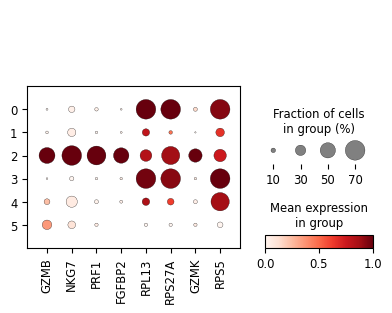

In [263]:
# Dotplot showing expression and % of cells expressing the genes
sc.pl.dotplot(adata, var_names=genes_to_plot, groupby='leiden', standard_scale='var', dot_max=0.7)

*Fig. 7* | *Expression of the top 4 overexpressed genes between k-mean cluster 2 and 3 for each leiden cluster.*

The differential expression analysis revealed a striking pattern: the **top 4 overexpressed genes in one subcluster (subcluster 2)** were highly expressed across most other clusters except for cluster 3, indicating that these genes are **not specific markers** and may reflect general expression patterns rather than a distinct cell population. In contrast, the **top 4 overexpressed genes in the other subcluster (subcluster 3)** were **lowly expressed in all other clusters**, consistent with a **specific and biologically meaningful population**. Notably, the gene **NKG7**, which is a canonical marker for **NK cells**, was overexpressed in cluster 2 compared to cluster 3, suggesting that cluster 2 likely represents **NK cells**, while cluster 3 represents a distinct population of cells with minimal NK cell characteristics. These findings highlight that while some genes differentiate subclusters, careful inspection of expression specificity is essential for interpreting biologically relevant differences.

## Supervised learning

In the second part of this analysis, we turn to **supervised learning**, where the goal is to build predictive models that can assign cell types to unseen data based on labeled training examples. This is particularly useful once reference cell type annotations are available, enabling automated classification of new cells. We compare three approaches of increasing complexity: a **regularized Logistic Regression** baseline, a **Random Forest classifier** as a non-linear ensemble method, and a **Multi-Layer Perceptron (MLP) neural network** implemented in PyTorch with early stopping and elastic net regularization. Model performance is evaluated on a held-out test set using accuracy, F1-score, precision, and recall, with both macro and weighted averaging to account for class imbalance. This allows us to benchmark traditional and deep learning strategies for cell type prediction.

### Prepare data for supervised machine learning

We split the dataset into training and test sets (80/20 split, stratified by cell type).

In [264]:
X = adata.X
y = adata.obs['cell_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed
)

### Logistic regression

We implement a Logistic Regression classifier with Elastic Net regularization to predict cell types from single-cell gene expression data. Since the dataset contains unbalanced classes, we use class_weight='balanced' so that the model gives appropriate weight to rare cell types. To optimize the model, we perform a stratified cross-validation grid search over the regularization strength (C) and the Elastic Net mixing parameter (l1_ratio), ensuring that each fold preserves the class distribution. This allows the model to find the best balance between L1 and L2 penalties while maintaining good predictive performance across all cell types. Finally, we evaluate the best model on the held-out test set and report classification metrics, including accuracy and weighted F1-score, to account for class imbalance.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 10, 'l1_ratio': 0.5}
Best CV score: 0.9814814814814816
=== Logistic Regression (Elastic Net) ===
                           precision    recall  f1-score   support

                  B cells       1.00      0.99      0.99        71
           Megakaryocytes       1.00      1.00      1.00         3
                Monocytes       1.00      1.00      1.00       130
Monocytes/Dendritic cells       1.00      1.00      1.00         7
                 NK cells       0.91      0.97      0.93        89
                  T cells       0.99      0.97      0.98       240

                 accuracy                           0.98       540
                macro avg       0.98      0.99      0.98       540
             weighted avg       0.98      0.98      0.98       540

Balanced accuracy: 0.9864790490759789
Weighted F1: 0.9780263172921855


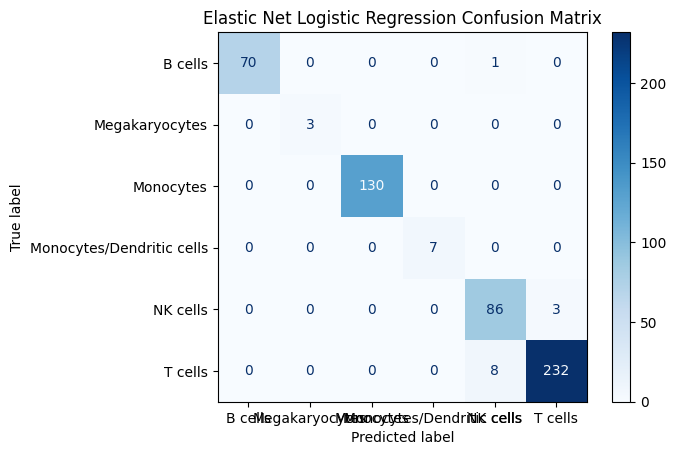

In [265]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.2, 0.5, 0.8],
}

logreg = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=2000,
    class_weight='balanced',
    random_state=seed
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid = GridSearchCV(logreg, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Evaluate on test set
best_logreg = grid.best_estimator_
y_pred = best_logreg.predict(X_test)

print("=== Logistic Regression (Elastic Net) ===")
print(classification_report(y_test, y_pred))

balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print("Balanced accuracy:", balanced_acc)
print("Weighted F1:", f1_weighted)

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test)).plot(cmap=plt.cm.Blues)
plt.title("Elastic Net Logistic Regression Confusion Matrix")
plt.show()

*Fig. 8* | *Confusion matrix of the Logistic Regression model predictions.*

### Random Forest Classifier

We train a Random Forest classifier to predict cell types from gene expression. To handle unbalanced classes, we set `class_weight='balanced'` so rare cell types receive appropriate importance. We also perform a grid search to tune the number
of trees (`n_estimators`) and maximum depth (`max_depth`). The best model is evaluated on the test set using accuracy, weighted F1-score, and confusion matrices.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'max_depth': 10, 'n_estimators': 200}
Best CV score: 0.9726851851851851
=== Random Forest Classification Report ===
                           precision    recall  f1-score   support

                  B cells       0.99      0.97      0.98        71
           Megakaryocytes       1.00      0.33      0.50         3
                Monocytes       0.98      1.00      0.99       130
Monocytes/Dendritic cells       1.00      0.57      0.73         7
                 NK cells       0.89      0.94      0.92        89
                  T cells       0.97      0.97      0.97       240

                 accuracy                           0.96       540
                macro avg       0.97      0.80      0.85       540
             weighted avg       0.96      0.96      0.96       540

Balanced accuracy: 0.7978466303438608
Weighted F1-score: 0.9616166859056564


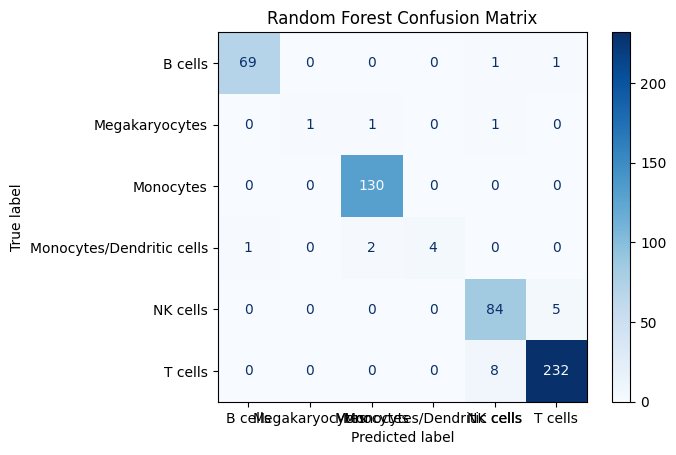

In [266]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
}

# Create Random Forest classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=seed)

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Grid search for best hyperparameters
grid_rf = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

# Best model
best_rf = grid_rf.best_estimator_
print("Best hyperparameters:", grid_rf.best_params_)
print("Best CV score:", grid_rf.best_score_)

# Predictions on test set
y_pred_rf = best_rf.predict(X_test)

# Classification report and weighted metrics
print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print("Weighted F1-score:", f1_score(y_test, y_pred_rf, average='weighted'))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=np.unique(y_test))
ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test)).plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

*Fig. 9* | *Confusion matrix of the Random Forest Classifier predictions.*

### Neural Network (MLP)

We implement a multi-layer perceptron (MLP) in PyTorch to predict cell types. To prevent overfitting, we introduce a class-based early stopping mechanism that monitors validation loss and stores the best model parameters. A separate validation set is used for early stopping, while the test set remains the same as in the Logistic Regression and Random Forest steps, allowing fair comparison of model performance. Evaluation metrics include accuracy, balanced accuracy, weighted F1-score, and confusion matrix.

#### Split train into proper training and validation sets
Test set remains the same for proper comparison between predictive models. 

In [267]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed
)

# Encode labels
cell_types = np.unique(y_train)
label2idx = {label: i for i, label in enumerate(cell_types)}
y_train_idx = np.array([label2idx[lab] for lab in y_train_sub])
y_val_idx = np.array([label2idx[lab] for lab in y_val])
y_test_idx = np.array([label2idx[lab] for lab in y_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_sub, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

#### Define EarlyStopping class

The class will contain a step method, that will store the best state of the model when the loss on the validation set is the lowest. 

In [268]:
class EarlyStopping:
    """Monitors validation loss and stores the best model state dict."""
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.best_state_dict = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_state_dict = model.state_dict()
            self.counter = 0
            return False  # do not stop
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # stop training
            return False

#### Define MLPClassifier class

We implement a Multi-Layer Perceptron (MLP) neural network in PyTorch. The architecture consists of an input layer matching the number of selected features (highly variable genes), followed by two fully connected hidden layers with ReLU activations and dropout regularization to reduce overfitting. The output layer produces one logit per cell type, which is converted into probabilities via the softmax function.

In [269]:
# -----------------------
# 9c: Define MLPClassifier class
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden1=256, hidden2=128, output_dim=6, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, output_dim)
        )

    def forward(self, x):
        return self.net(x)

    def predict(self, x):
        """
        Returns predicted class labels for input x.
        - x: torch.Tensor or numpy.ndarray of shape (n_samples, n_features)
        """
        # Ensure input is a torch tensor
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)

        self.eval()  # evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            preds = torch.argmax(logits, dim=1)
        return preds.cpu().numpy()

#### Training loop

The model is trained using cross-entropy loss and the Adam optimizer, with elastic net regularization (combining L1 and L2 penalties) to enforce sparsity and prevent overfitting. The custom early stopping mechanism monitors validation loss during training and restores the best-performing model parameters. 

In [270]:
input_dim = X_train_tensor.shape[1]
output_dim = len(cell_types)
model = MLPClassifier(input_dim=input_dim, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopper = EarlyStopping(patience=5)
epochs = 50
batch_size = 64

for epoch in range(epochs):
    # Training
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))
    train_loss = 0
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= (X_train_tensor.size(0) // batch_size + 1)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if early_stopper.step(val_loss, model):
        print("Early stopping triggered.")
        break

# Load best model
model.load_state_dict(early_stopper.best_state_dict)

Epoch 1, Train Loss: 0.7138, Val Loss: 0.1548
Epoch 2, Train Loss: 0.0595, Val Loss: 0.0805
Epoch 3, Train Loss: 0.0162, Val Loss: 0.0905
Epoch 4, Train Loss: 0.0036, Val Loss: 0.0727
Epoch 5, Train Loss: 0.0018, Val Loss: 0.0744
Epoch 6, Train Loss: 0.0009, Val Loss: 0.0779
Epoch 7, Train Loss: 0.0010, Val Loss: 0.0762
Epoch 8, Train Loss: 0.0007, Val Loss: 0.0762
Epoch 9, Train Loss: 0.0005, Val Loss: 0.0763
Early stopping triggered.


<All keys matched successfully>

#### Evaluate on the test set

=== PyTorch MLP Classification Report ===
                           precision    recall  f1-score   support

                  B cells       1.00      0.99      0.99        71
           Megakaryocytes       1.00      0.67      0.80         3
                Monocytes       0.99      1.00      1.00       130
Monocytes/Dendritic cells       1.00      0.86      0.92         7
                 NK cells       0.91      0.98      0.94        89
                  T cells       0.99      0.97      0.98       240

                 accuracy                           0.98       540
                macro avg       0.98      0.91      0.94       540
             weighted avg       0.98      0.98      0.98       540

Balanced accuracy: 0.9096810733313739
Weighted F1-score: 0.9778160143668804


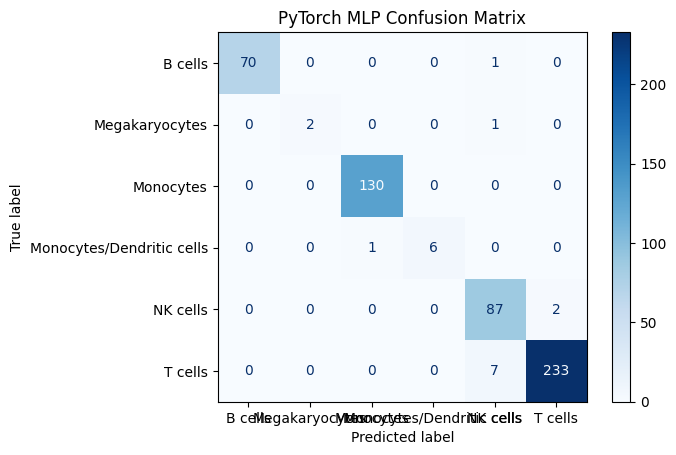

In [271]:
y_pred_idx = model.predict(X_test_tensor)
y_pred = [cell_types[i] for i in y_pred_idx]

print("=== PyTorch MLP Classification Report ===")
print(classification_report(y_test, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Weighted F1-score:", f1_score(y_test, y_pred, average='weighted'))

cm = confusion_matrix(y_test, y_pred, labels=cell_types)
ConfusionMatrixDisplay(cm, display_labels=cell_types).plot(cmap=plt.cm.Blues)
plt.title("PyTorch MLP Confusion Matrix")
plt.show()

*Fig. 10* | *Confusion matrix of the MLP model predictions.*

### Predictive model comparison

In [272]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Collect predictions from your models
y_pred_logreg = best_logreg.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_mlp = [cell_types[i] for i in model.predict(X_test_tensor)]


# Compute metrics
results = {
    "Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred_logreg),
        "Balanced accuracy": balanced_accuracy_score(y_test, y_pred_logreg),
        "F1 (weighted)": f1_score(y_test, y_pred_logreg, average="weighted"),
        "Precision (weighted)": precision_score(y_test, y_pred_logreg, average="weighted"),
        "Recall (weighted)": recall_score(y_test, y_pred_logreg, average="weighted"),
    },
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Balanced accuracy": balanced_accuracy_score(y_test, y_pred_rf),
        "F1 (weighted)": f1_score(y_test, y_pred_rf, average="weighted"),
        "Precision (weighted)": precision_score(y_test, y_pred_rf, average="weighted"),
        "Recall (weighted)": recall_score(y_test, y_pred_rf, average="weighted"),
    },
    "MLP": {
        "Accuracy": accuracy_score(y_test, y_pred_mlp),
        "Balanced accuracy": balanced_accuracy_score(y_test, y_pred_mlp),
        "F1 (weighted)": f1_score(y_test, y_pred_mlp, average="weighted"),
        "Precision (weighted)": precision_score(y_test, y_pred_mlp, average="weighted"),
        "Recall (weighted)": recall_score(y_test, y_pred_mlp, average="weighted"),
    }
}

# Create DataFrame for nice display
results_df = pd.DataFrame(results).T
display(results_df.round(3))


,Accuracy,Balanced accuracy,F1 (weighted),Precision (weighted),Recall (weighted)
Logistic Regression,0.978,0.986,0.978,0.979,0.978
Random Forest,0.963,0.798,0.962,0.964,0.963
MLP,0.978,0.910,0.978,0.979,0.978


All three predictive models — **Logistic Regression**, **Random Forest**, and the **Multi-Layer Perceptron (MLP)** — achieved high overall accuracy (~96–98%) on the test set, confirming that cell types in the PBMC3k dataset can be reliably distinguished from gene expression features. Logistic Regression and the MLP performed best, reaching **0.978 accuracy and weighted F1-score**, and both showed strong precision and recall across classes. Logistic Regression achieved the highest **balanced accuracy (0.986)**, indicating excellent performance even on minority cell types.  

In contrast, the Random Forest showed slightly lower overall performance, particularly in terms of balanced accuracy (0.798), suggesting that it struggled more with rare populations despite using class balancing. This highlights that while ensemble methods can capture non-linear relationships, they may not always handle imbalanced classes as effectively as linear or neural models in this context.  

Overall, these results demonstrate that **regularized linear models (Logistic Regression) and neural networks (MLP) are highly effective for single-cell classification**, with Logistic Regression offering the best balance of simplicity, interpretability, and robustness, while the MLP provides a flexible non-linear alternative that may prove advantageous in more complex datasets.  

**Take-home message:** Machine learning provides a powerful toolkit for single-cell transcriptomics, with both unsupervised and supervised approaches contributing to the discovery and accurate annotation of cellular populations.  